In [1]:
import pandas as pd

# File path (update with correct file name)
file_path = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\customer_scorecard_input.xlsx"

# Read all 2 sheets
application_df = pd.read_excel(file_path, sheet_name="Application_Data")
behavioral_df = pd.read_excel(file_path, sheet_name="Behavioral_Data")

In [2]:
# Bureau data (update with correct file name)
file_path = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\bureau_data.xlsx"
bureau_df = pd.read_excel(file_path, sheet_name="Bureau_Data")


In [3]:
# Merge them into one dataset using Customer_ID
merged_df = application_df.merge(behavioral_df, on="Customer_ID") \
                          .merge(bureau_df, on="Customer_ID")

In [4]:
# Quick check
#print("Application Data shape:", application_df.shape)
#print("Behavioral Data shape:", behavioral_df.shape)
#print("Bureau Data shape:", bureau_df.shape)
#print("Final merged shape:", merged_df.shape)

# Show first few rows
print(merged_df.head(10))

   Customer_ID  Age  Income_INR  Employment_Years Marital_Status  \
0            1   59     2309818                 0       Divorced   
1            2   49     2431785                 8       Divorced   
2            3   35      488998                27         Single   
3            4   63     2043400                26         Single   
4            5   28     1279111                 5       Divorced   
5            6   41     1196107                15       Divorced   
6            7   59      551279                28        Married   
7            8   39     2070230                 2       Divorced   
8            9   43      689570                19        Married   
9           10   31     2250731                27        Married   

  Education_Level  Credit_History_Length  Outstanding_Loans  Loan_Amount  \
0        Graduate                      5                  9       448929   
1    Postgraduate                     12                  6       630466   
2        Graduate      

In [7]:
# STEP 2 - MODEL DEVELOPMET ( TARGET VARIAVLE CREATION < VINTAGE ANALYSIS< SAMPLING)

# Create the full path to the Desktop and the file
desktop_file_path = r'C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\merged_customer_data.xlsx'

# Save the DataFrame to the Desktop
merged_df.to_excel(desktop_file_path, index=False)

print(f"File successfully saved to your desktop: {desktop_file_path}")

File successfully saved to your desktop: C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\merged_customer_data.xlsx


Columns in DataFrame:
['Customer_ID', 'Age', 'Income_INR', 'Employment_Years', 'Marital_Status', 'Education_Level', 'Credit_History_Length', 'Outstanding_Loans', 'Loan_Amount', 'Loan_Tenure_Months', 'Savings_Account_Balance', 'Checking_Account_Balance', 'Pay_History', 'Delinquency_12M', 'Credit_Card_Utilization', 'Behavior_Spending_Score', 'Behavior_Repayment_Score', 'Default_x', 'No_of_Open_Accounts', 'No_of_Closed_Accounts', 'Total_Credit_Limit', 'Total_Current_Balance', 'Credit_Utilization_Ratio', 'No_of_Inquiries_6M', 'No_of_Inquiries_12M', 'DPD_30', 'DPD_60', 'DPD_90', 'Worst_Current_Status', 'Months_Since_Most_Recent_Delinquency', 'Max_Credit_Exposure', 'Oldest_Trade_Open_Months', 'Newest_Trade_Open_Months', 'Default_y', 'Bad_Flag']

⚠️ No date column found. Creating synthetic 'Application_Date' for demonstration.

Vintage summary saved!


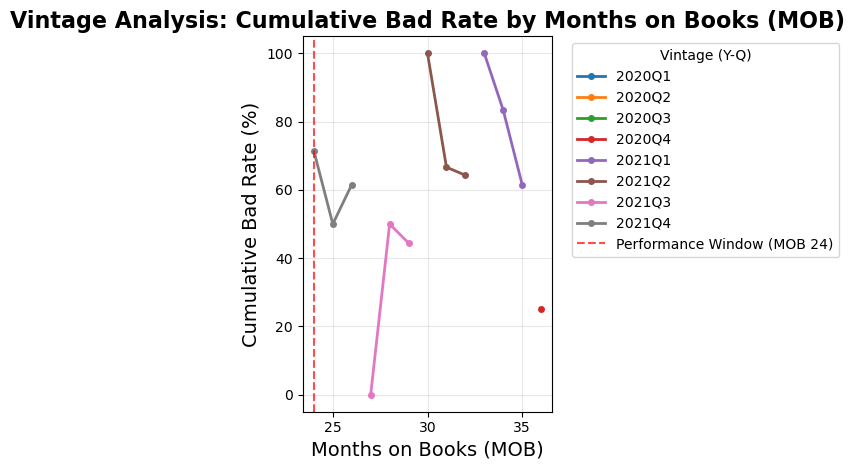


--- Vintage Summary (Cumulative Bad Rate at MOB 24+) ---
  Vintage_Str  Total_Accounts  Total_Bads  Cumulative_Bad_Rate
0      2020Q1              14           9                64.29
1      2020Q2              12           6                50.00
2      2020Q3              15           9                60.00
3      2020Q4              10           6                60.00
4      2021Q1              13           8                61.54
5      2021Q2              14           9                64.29
6      2021Q3               9           4                44.44
7      2021Q4              13           8                61.54

Vintage summary saved to: C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Vintage_Summary.xlsx


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil.relativedelta import relativedelta

# --------------------------
# 1. Load the merged Excel file
# --------------------------
file_path = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\merged_customer_data.xlsx"
merged_df = pd.read_excel(file_path)

# --------------------------
# 2. Define the Bad Indicator
# --------------------------
# Assuming 'DPD_90' is the number of times they were 90+ DPD.
# Mark Bad (=1) if they were ever 90+ DPD (DPD_90 >= 1).
merged_df['Bad_Flag'] = (merged_df['DPD_90'] >= 1).astype(int)

# --------------------------
# 3. Identify / Create Date Column
# --------------------------
print("Columns in DataFrame:")
print(merged_df.columns.tolist())

# Try to auto-detect a likely date column
possible_date_cols = [col for col in merged_df.columns if "date" in col.lower()]

if possible_date_cols:
    date_column = possible_date_cols[0]  # take the first matching column
    print(f"\nUsing detected date column: {date_column}")
    merged_df[date_column] = pd.to_datetime(merged_df[date_column])
else:
    print("\n⚠️ No date column found. Creating synthetic 'Application_Date' for demonstration.")
    np.random.seed(42)
    start_date = pd.to_datetime('2020-01-01')
    end_date = pd.to_datetime('2021-12-31')
    random_dates = pd.to_datetime(
        np.random.choice(pd.date_range(start_date, end_date), size=len(merged_df))
    )
    merged_df['Application_Date'] = random_dates
    date_column = 'Application_Date'                   # Step 3 ke baad har CustomerID ke against ek hi standardized date aayegi

# --------------------------
# 4. Create Vintage Column
# --------------------------
merged_df['Vintage'] = merged_df[date_column].dt.to_period('Q')
merged_df['Vintage_Str'] = merged_df['Vintage'].astype(str)  # Important for splits

# --------------------------
# 5. Calculate Months on Books (MOB) using relativedelta
# --------------------------
def calculate_mob(open_date, analysis_date):
    rd = relativedelta(analysis_date, open_date)
    return rd.years * 12 + rd.months

analysis_date = pd.to_datetime('2023-12-31')
merged_df['MOB'] = merged_df[date_column].apply(lambda x: calculate_mob(x, analysis_date))
#Har row ke liye ApplicationDate (ya jo bhi tumhara date_column hai) par function run hoga aur ek naya column MOB ban 
#jayegaHar row ke liye ApplicationDate (ya jo bhi tumhara date_column hai) par function run hoga aur ek naya column MOB ban 
#jayegaHar row ke liye ApplicationDate (ya jo bhi tumhara date_column hai) par function run hoga aur ek naya column MOB ban jayega

# --------------------------
# 6. Filter by Performance Window
# --------------------------
performance_window = 24
vintage_df = merged_df[merged_df['MOB'] >= performance_window].copy()        #FILTERING 24 MONTHS OLD ACCOUNTS

# --------------------------
# 7. Vintage Summary
# --------------------------
vintage_summary = vintage_df.groupby('Vintage').agg(        # Data ko Vintage level (Y-Q) par group kar raha hai (jaise 2020Q1, 2020Q2 etc).
    Total_Accounts=('Customer_ID', 'count'),                # Har vintage me kitne accounts open hue the (jo >= 24 MOB wale hain).
    Total_Bads=('Bad_Flag', 'sum')                          # Har vintage me kitne customers bad nikle (Bad_Flag=1).
).reset_index()

vintage_summary['Cumulative_Bad_Rate'] = (vintage_summary['Total_Bads'] / vintage_summary['Total_Accounts']) * 100
vintage_summary['Vintage_Str'] = vintage_summary['Vintage'].astype(str)

# Save vintage summary
vintage_summary.to_excel(r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Vintage_Summary.xlsx", index=False)
print("\nVintage summary saved!")

# --------------------------
# 8. Vintage Analysis Plot
# --------------------------
#Ye code har Vintage (Y-Q) ke liye 0–36 months tak ka Cumulative Bad Rate vs MOB plot karta hai aur ek red dashed line dikhata hai jahan performance window (24 MOB) complete hoti hai.
#👉 Output ek line chart hoga jisme har vintage alag-alag curve ke form me dikhega.
#plt.figure(figsize=(14, 8))

for vintage in vintage_summary['Vintage'].unique():
    vintage_data = vintage_df[vintage_df['Vintage'] == vintage]
    mob_summary = vintage_data.groupby('MOB')['Bad_Flag'].agg(['count', 'sum'])
    mob_summary = mob_summary.cumsum().reset_index()
    mob_summary['Bad_Rate'] = (mob_summary['sum'] / mob_summary['count']) * 100
    mob_summary = mob_summary[mob_summary['MOB'] <= 36]
    plt.plot(mob_summary['MOB'], mob_summary['Bad_Rate'],
             label=str(vintage), marker='o', markersize=4, linewidth=2)

plt.title('Vintage Analysis: Cumulative Bad Rate by Months on Books (MOB)', fontsize=16, fontweight='bold')
plt.xlabel('Months on Books (MOB)', fontsize=14)
plt.ylabel('Cumulative Bad Rate (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axvline(x=performance_window, color='red', linestyle='--', alpha=0.7,
            label=f'Performance Window (MOB {performance_window})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Vintage (Y-Q)')
plt.tight_layout()
plt.show()

# --------------------------
# 9. Print Vintage Summary
# --------------------------
print("\n--- Vintage Summary (Cumulative Bad Rate at MOB 24+) ---")
print(vintage_summary[['Vintage_Str', 'Total_Accounts', 'Total_Bads', 'Cumulative_Bad_Rate']].round(2))

# --------------------------
# 10. (Optional) Save Results to Excel
# --------------------------
output_path = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Vintage_Summary.xlsx"
vintage_summary.to_excel(output_path, index=False)
print(f"\nVintage summary saved to: {output_path}")





In [19]:
# --------------------------
# 9. Sampling: Train/Test/OOT
# --------------------------
# Define OOT (latest vintages)
oot_vintages = ['2021Q3', '2021Q4']
oot_df = vintage_df[vintage_df['Vintage_Str'].isin(oot_vintages)].copy()

# Remaining vintages for train/test
train_test_df = vintage_df[~vintage_df['Vintage_Str'].isin(oot_vintages)].copy()

# Train/Test Split (70/30)
train_df, test_df = train_test_split(
    train_test_df,
    test_size=0.3,
    random_state=42,
    stratify=train_test_df['Bad_Flag']
)

# Quick summary
print("\nTrain size:", train_df.shape[0], "| Bad Rate:", round(train_df['Bad_Flag'].mean()*100,2), "%")
print("Test size:", test_df.shape[0], "| Bad Rate:", round(test_df['Bad_Flag'].mean()*100,2), "%")
print("OOT size:", oot_df.shape[0], "| Bad Rate:", round(oot_df['Bad_Flag'].mean()*100,2), "%")


Train size: 54 | Bad Rate: 61.11 %
Test size: 24 | Bad Rate: 58.33 %
OOT size: 22 | Bad Rate: 54.55 %
